In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Data 

Please, download the data to your working folder.On the webpage you can find its description. 

https://archive.ics.uci.edu/ml/datasets/Iris


In [2]:
df = pd.read_csv("iris.data")
df.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]

# Classification

## Logistic Regression

In [3]:
log_df = df[(df.species == 'Iris-versicolor') | (df.species == 'Iris-virginica')]
log_df_x = log_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
log_df_y = (log_df.species == 'Iris-versicolor').astype(int)

x_train, x_test, y_train, y_test = train_test_split(log_df_x, log_df_y)

### Implement the "loss" function for Logistic Regression 

In [4]:
def loss(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

### Implement the "fit" function gradient descent

In [5]:
def sigmoid(x, weight):
    z = np.dot(x, weight)
    return 1 / (1 + np.exp(-z))

def gradient_descent(X, h, y):
    return np.dot(X.T, (h - y)) / y.shape[0]
     
def fit(lr, iterations):
    global weight
    global loss_iteration
    
    weight = np.zeros(x_train.shape[1])
    loss_iteration = []
    
    for i in range(iterations):
        sigma = sigmoid(x_train, weight)
         
        loss_iteration.append(loss(sigma, y_train))    
 
        dW = gradient_descent(x_train, sigma, y_train)
             
        weight -= lr * dW

### Implement predict function

In [6]:
def predict(x_new , treshold):
    result = sigmoid(x_new, weight)
    result = result >= treshold
                 
    return result.astype(int)

### To evaluate the model, use accuracy, precision and recall metrics 

In [7]:
fit(0.01, 1000)
y_pred = predict(x_test, 0.5)

In [8]:
accuracy_score(y_test, y_pred)

0.92

In [9]:
precision_score(y_test, y_pred)

1.0

In [10]:
recall_score(y_test, y_pred)

0.8333333333333334

### Choose the best learning rate

In [11]:
rates = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
bestRate = rates[0]
bestScore = 0

for rate in rates:
    fit(rate, 1000)
    y_pred = predict(x_test, 0.5)
    score = accuracy_score(y_test, y_pred)
    if score > bestScore:
        bestRate = rate
        bestScore = score

print("best learning rate is", bestRate)

best learning rate is 0.1


### Plot loss output depending on iteration 

In [12]:
fit(bestRate, 3000)

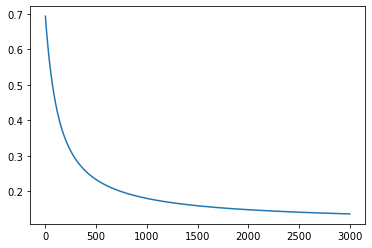

In [13]:
plt.plot(loss_iteration)

### Report the prediction accuracy on test data

In [14]:
y_pred = predict(x_test, 0.5)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.92      0.96        12

    accuracy                           0.96        25
   macro avg       0.96      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25



## K-NN classification

### Create training/validation/test datasets with 80/10/10 ratio. Make sure that they do not overlap

In [36]:
k_df = df.copy()
le = preprocessing.LabelEncoder()
le.fit(df.species)
k_df.species = le.transform(df.species)

In [37]:
train, test = train_test_split(k_df, test_size=0.2)
test, val = train_test_split(test, test_size=0.5)

### Implement the K-NN algorithm: create two functions, fit() - that is responsible for training and predict() - which is responsible for predicting the values for new data points
 

In [38]:
def fit(train_data):
    global train
    train = train_data

In [39]:
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

def get_neighbors(train, test_row, num_neighbors):
    distances = list()
    for index, train_row in train.iterrows():
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

def predict_classification(train, test_row, num_neighbors):
    neighbors = get_neighbors(train, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

def predict(test, num_neighbors = 10):
    predictions = []
    for index, test_row in test.iterrows():
        predictions.append(predict_classification(train, test_row, num_neighbors))
    return predictions

### For evaluation we will use "accuracy" metric - implement it :)

In [40]:
fit(train)
pred = predict(test)

In [41]:
def custom_accuracy_score(true, pred):
    count = 0
    for i in range(len(pred)):
        if true[i] == pred[i]:
            count += 1
        
    return count / len(pred)

In [42]:
custom_accuracy_score(test.species.tolist(), pred)

0.8666666666666667

### Choose the best "k" value and report the accuracy for all k-values you have tried on validation data

In [43]:
def accuracy_score_for(k):
    fit(train)
    pred = predict(test, k)
    return custom_accuracy_score(test.species.tolist(), pred)

In [44]:
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 25, 50, 100]
best_k = 0
best_score = 0

for k in k_values:
    score = accuracy_score_for(k)
    if score > best_score:
        best_k = k
        best_score = score
        
print("best k is", best_k)

best k is 4


### Report the accuracy for the best value of k on test data

In [45]:
fit(train)
pred = predict(test, best_k)

In [46]:
print(classification_report(test.species, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

